In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import numpy as np
import numpy.random as npr
from tqdm import tqdm
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from cnf import CNF
from neural_ode import NeuralODE

In [7]:
from sklearn.datasets import make_moons
num_samples = 512

cnf_net = CNF(input_dim=2, hidden_dim=32, n_ensemble=16)
ode = NeuralODE(model=cnf_net, t=np.linspace(1, 0.0, 10))

In [8]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2, beta2=0.99)

In [9]:
def compute_gradients_and_update(h0):    
    hN = ode.forward(inputs=h0)
    with tf.GradientTape() as g:
        g.watch(hN)
        xN, logdetN = hN[:, :2], hN[:, 2]
        # L = log(p(zN))
        mle = tf.reduce_sum(p0.log_prob(xN), -1)
        # loss to minimize
        loss = -tf.reduce_mean(mle - logdetN)

    dloss = g.gradient(loss, hN)
    h0_rec, dLdh0, dLdW = ode.backward(hN, dloss)          
    optimizer.apply_gradients(zip(dLdW, cnf_net.weights))
    return loss

compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

  0%|          | 0/1100 [00:00<?, ?it/s]

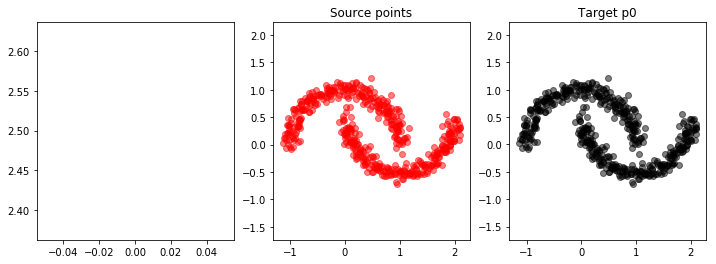

 18%|█▊        | 199/1100 [00:27<02:04,  7.25it/s]

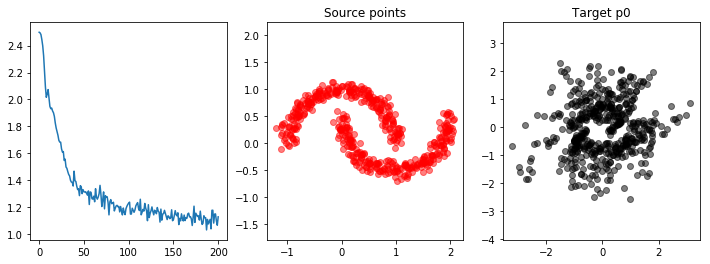

 36%|███▋      | 399/1100 [00:40<01:11,  9.87it/s]

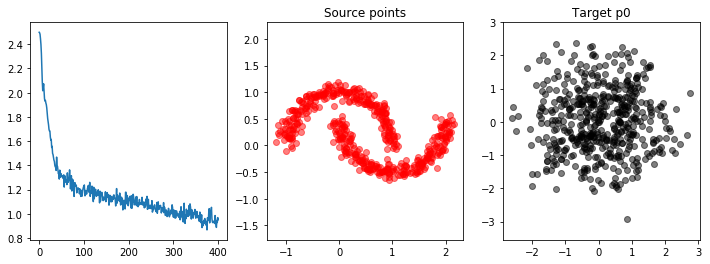

 54%|█████▍    | 599/1100 [00:53<00:44, 11.21it/s]

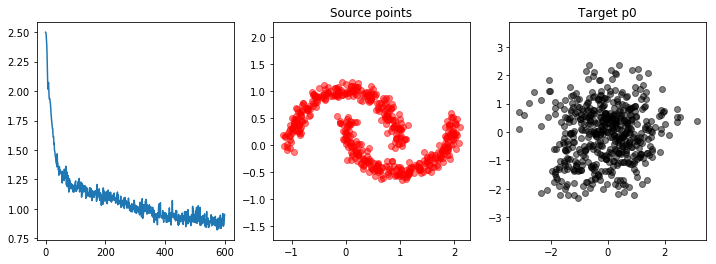

 73%|███████▎  | 799/1100 [01:05<00:24, 12.22it/s]

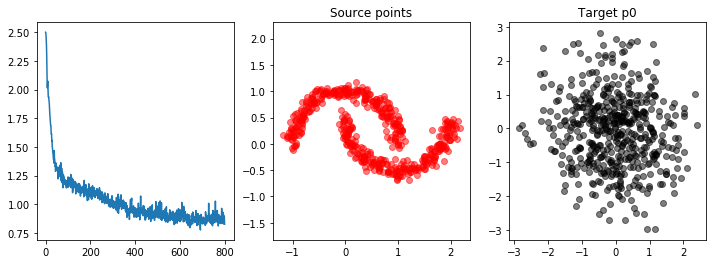

 91%|█████████ | 999/1100 [01:18<00:07, 12.70it/s]

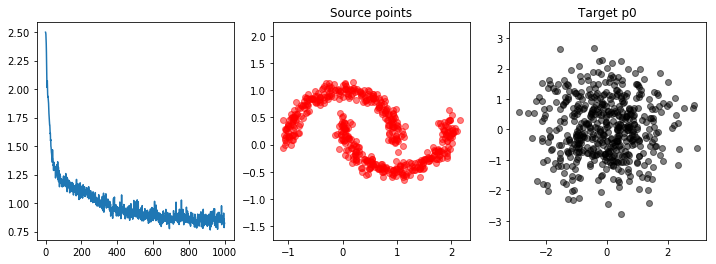

100%|██████████| 1100/1100 [01:26<00:00, 12.74it/s]


In [10]:
loss_history = []
for step in tqdm(range(1100)):
    p0 = tf.distributions.Normal(loc=[0.0, 0.0], scale=[1.0, 1.0])
    x0 = tf.to_float(make_moons(n_samples=num_samples, noise=0.08)[0])
    logdet0 = tf.zeros([num_samples, 1])
    h0 = tf.concat([x0, logdet0], axis=1)
    loss = compute_gradients_and_update(h0)
    loss_history.append(loss.numpy())
    if step % 200 == 0:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.plot(loss_history)
        plt.subplot(132)
        hN = ode.forward(h0)
        xN, logdetN = hN[:, :2], hN[:, 2]        
        plt.title("Source points")
        plt.scatter(*x0.numpy().T, color='r', alpha=0.5)        
        plt.axis("equal")
        plt.subplot(133)        
        plt.title("Target p0")
        plt.scatter(*xN.numpy().T, color='k', alpha=0.5)
        plt.axis("equal")
        plt.show()

In [11]:
ode = NeuralODE(model=cnf_net, t=np.linspace(0, 1.0, 20))
h0_reconstruction = ode.forward(inputs=hN)

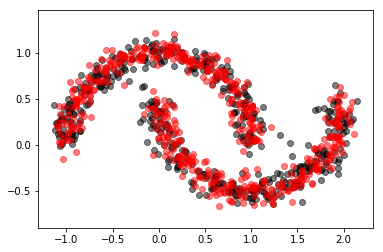

In [12]:
x0_rec = h0_reconstruction[:, :2]
plt.scatter(*x0_rec.numpy().T, color='k', alpha=0.5)
plt.scatter(*x0.numpy().T, color='r', alpha=0.5)
_ = plt.axis("equal")

In [13]:
hN_sample = tf.concat([p0.sample(num_samples), logdet0], axis=1)
h0_reconstruction = ode.forward(inputs=hN_sample)

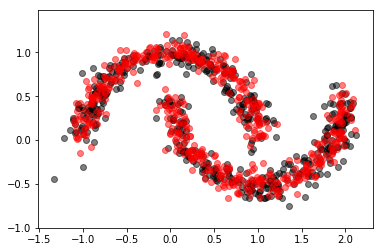

In [14]:
x0_rec = h0_reconstruction[:, :2]
plt.scatter(*x0_rec.numpy().T, color='k', alpha=0.5)
plt.scatter(*x0.numpy().T, color='r', alpha=0.5)
_ = plt.axis("equal")

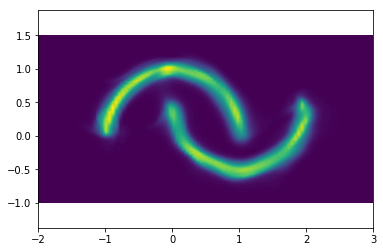

In [33]:
vx = np.linspace(-2, 3, 100)
vy = np.linspace(-1, 1.5, 100)
points = np.vstack(np.meshgrid(vx, vy)).reshape([2, -1]).T

x0 = tf.to_float(points)
logdet0 = tf.zeros([points.shape[0], 1])
h0_sample = tf.concat([x0, logdet0], axis=1)

h0_reconstruction = NeuralODE(model=cnf_net, t=np.linspace(1, 0.0, 10)).forward(inputs=h0_sample)
x0_rec, x0_logdet = h0_reconstruction[:, :2], h0_reconstruction[:, 2]
logp = tf.reduce_sum(p0.log_prob(x0_rec), -1) - x0_logdet
plt.tricontourf(*x0.numpy().T, np.exp(logp.numpy()), 200)
_ = plt.axis("equal")

In [17]:
vx = np.linspace(-5, 5, 100)
vy = np.linspace(-5, 5, 100)
points = np.vstack(np.meshgrid(vx, vy)).reshape([2, -1]).T

In [19]:
def w1(z):
    return tf.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tf.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tf.exp(-(z[0]-1.)/.3))**-1

def potential_energy(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0) - 2.)/.4)**2 \
        - tf.log(tf.exp(-.5*((z[0]-2.)/.6)**2) + tf.exp(-.5*((z[0]+2.)/.6)**2))

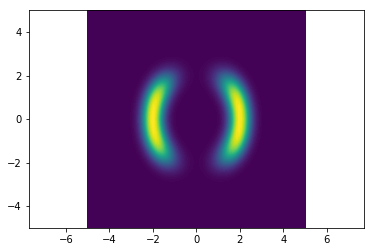

In [20]:
probs = potential_energy(tf.to_float(points)).numpy()
plt.tricontourf(points[:, 0], points[:, 1], np.exp(-probs), 100)
plt.axis('equal') 
plt.xlim([-5, 5])
_ = plt.ylim([-5, 5])

In [29]:
num_samples = 512
cnf_net = CNF(input_dim=2, hidden_dim=32, n_ensemble=16)
ode = NeuralODE(model=cnf_net, t=np.linspace(1, 0, 10))

In [30]:
def compute_gradients_and_update(h0, optimizer):
    hN = ode.forward(inputs=h0)
    with tf.GradientTape() as g:
        g.watch(hN)
        xN, logdetN = hN[:, :2], hN[:, 2]
        # L = log(p(xN)) = log(-E(xN))
        mle = - potential_energy(xN)
        # loss to minimize
        loss = - tf.reduce_mean(mle - logdetN)

    dloss = g.gradient(loss, hN)
    h0_rec, dLdh0, dLdW = ode.backward(hN, dloss)          
    optimizer.apply_gradients(zip(dLdW, cnf_net.weights))
    return loss

compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

In [31]:
loss_history = []

In [96]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

  0%|          | 0/1001 [00:00<?, ?it/s]

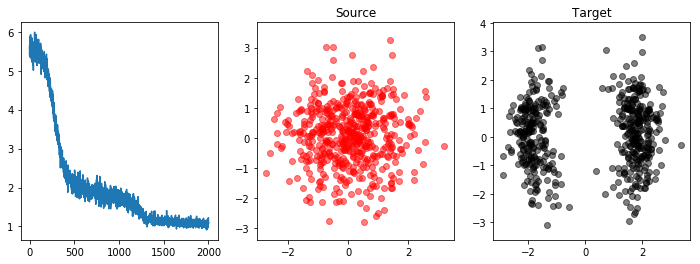

 20%|█▉        | 199/1001 [01:13<04:54,  2.72it/s] 

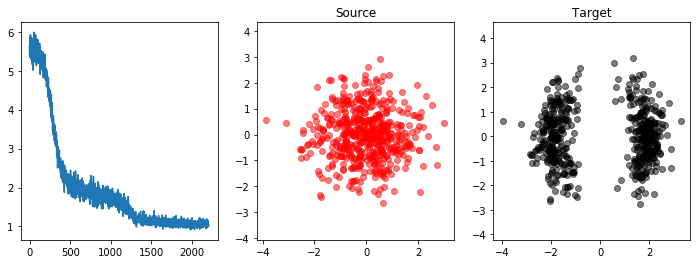

 40%|███▉      | 399/1001 [01:26<02:10,  4.60it/s]

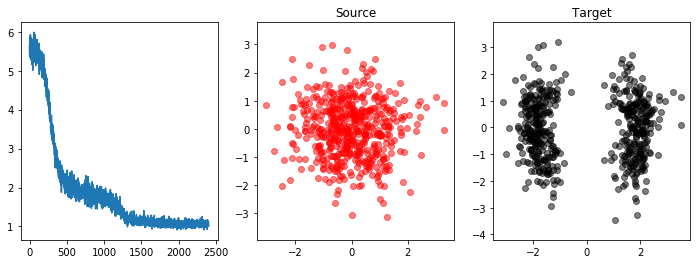

 60%|█████▉    | 599/1001 [01:39<01:06,  6.01it/s]

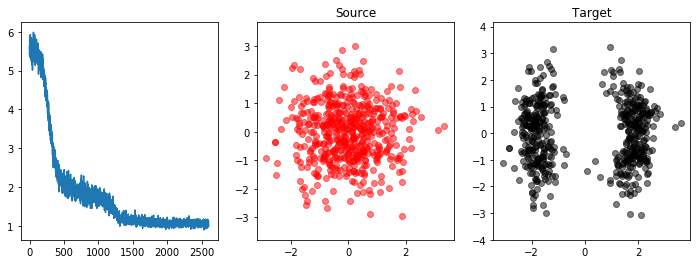

 80%|███████▉  | 799/1001 [01:52<00:28,  7.07it/s]

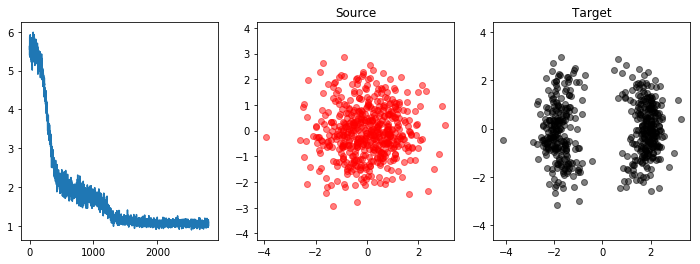

100%|█████████▉| 999/1001 [02:05<00:00,  7.94it/s]

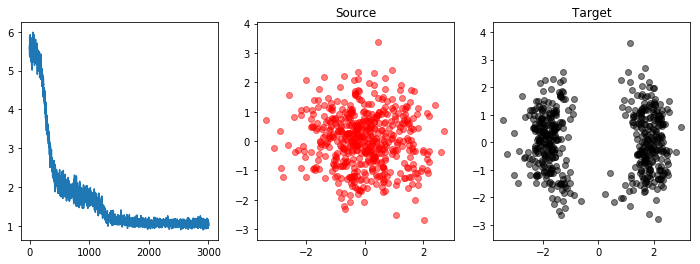

100%|██████████| 1001/1001 [02:06<00:00,  7.93it/s]


In [97]:
for step in tqdm(range(1001)):
    logdet0 = tf.zeros([num_samples, 1])
    x0 = tf.random_normal([num_samples, 2])
    h0 = tf.concat([x0, logdet0], axis=1)
    
    loss = compute_gradients_and_update(h0, optimizer)
    loss_history.append(loss.numpy())
    if step % 200 == 0:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.plot(loss_history)
        plt.subplot(132)
        hN = ode.forward(h0)
        xN, logdetN = hN[:, :2], hN[:, 2]        
        plt.title("Source")
        plt.scatter(*x0.numpy().T, color='r', alpha=0.5)        
        plt.axis("equal")
        plt.subplot(133)
        plt.title("Target")        
        plt.scatter(*xN.numpy().T, color='k', alpha=0.5)
        plt.axis("equal")
        plt.show()

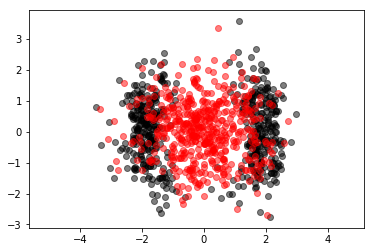

In [98]:
hN = ode.forward(h0)
xN, logdetN = hN[:, :2], hN[:, 2]
plt.scatter(*xN.numpy().T, color='k', alpha=0.5)
plt.scatter(*x0.numpy().T, color='r', alpha=0.5)
_ = plt.axis("equal")

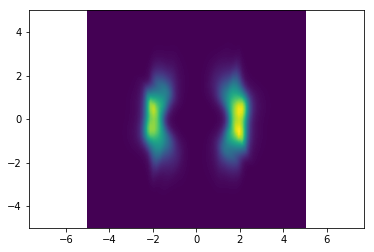

In [99]:
x = np.linspace(-5, 5, 80)
y = np.linspace(-5, 5, 80)
xv, yv = np.meshgrid(x, y)
xy = tf.to_float(np.concatenate([xv, yv]).reshape([2, -1]).T)
logdet0 = tf.zeros([xy.shape[0], 1])
h0 = tf.to_float(tf.concat([xy, logdet0], axis=1))
hN = NeuralODE(model=cnf_net, t=np.linspace(0, 1, 20)).forward(h0)
xN, logdetN = hN[:, :2], hN[:, 2]

p0 = tf.distributions.Normal(loc=[0.0, 0.0], scale=[1.0, 1.0])
logp = tf.reduce_sum(p0.log_prob(xN), -1) - logdetN
plt.tricontourf(*xy.numpy().T, np.exp(logp.numpy()), 200)
_ = plt.axis("equal")

In [100]:
from neural_ode import defun_neural_ode
defun_ode = defun_neural_ode(ode)

In [101]:
logdet0 = tf.zeros([num_samples, 1])
events = []
for i in tqdm(range(1000)):
    x0 = tf.random_normal([num_samples, 2])
    h0 = tf.concat([x0, logdet0], axis=1)
    hN = defun_ode.forward(h0)
    xN, logdetN = hN[:, :2], hN[:, 2]
    events.append(xN.numpy())
    
hN_samples = np.concatenate(events)

100%|██████████| 1000/1000 [00:14<00:00, 66.76it/s]


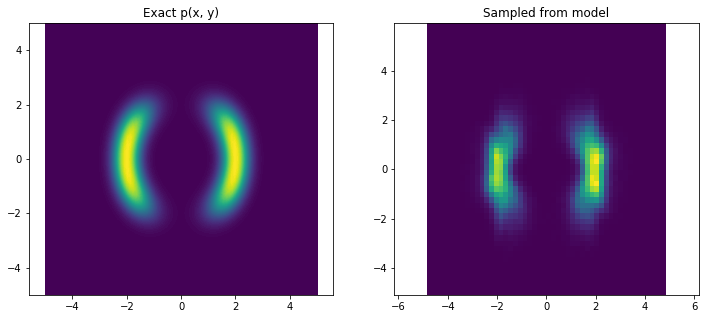

In [102]:
vx = np.linspace(-5, 5, 100)
vy = np.linspace(-5, 5, 100)
points = np.vstack(np.meshgrid(vx, vy)).reshape([2, -1]).T
probs = potential_energy(tf.to_float(points)).numpy()

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Exact p(x, y)")
plt.tricontourf(points[:, 0], points[:, 1], np.exp(-probs), 100)
plt.axis('equal') 

plt.xlim([-5, 5])
_ = plt.ylim([-5, 5])
plt.subplot(122)
plt.title("Sampled from model")
_ = plt.hist2d(hN_samples[:, 0], hN_samples[:, 1], 50)
_ = plt.axis('equal')